In [12]:
import pandas as pd
import numpy as np
import sqlite3
from plotnine import *

pd.options.display.max_rows = 999

In [13]:
dt = pd.read_csv('../processing/test_train_split.csv')
dt.head()

,track_id,genre,has_musical_ftr,has_lyrics,image_name,has_cover_img,cover_id,is_test
0,TRAAAAV128F421A322,Punk,1,1.0,4b3cc7ae-654e-4408-89e1-4ea70cf86717,1.0,70206.0,0
1,TRAAAEF128F4273421,Pop_Indie,1,1.0,c1f9b340-a37e-4dc8-aaf9-f622c5457f1a,1.0,21597.0,0
2,TRAAAHJ128F931194C,Pop_Indie,1,1.0,dc9b75f9-d5e7-434a-82c4-0d4e9790efd4,1.0,1330.0,0
3,TRAAAHZ128E0799171,Hip_Hop_Rap,1,1.0,62a1cd53-1339-4f04-8113-287b174c3917,1.0,33631.0,2
4,TRAAAJG128F9308A25,Country_Traditional,1,1.0,0cee21c0-9657-469c-9a72-b81bacc88eee,1.0,40306.0,1


In [16]:
# get lyrics data
conn = sqlite3.connect('/storage/thesis/lyrics/mxm_dataset.db')
lyr = pd.read_sql_query("SELECT * FROM lyrics", conn)
lyr.head(1)

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0


In [17]:
# filtered down to just the tracks we care about
lyrf = (lyr.drop('is_test', axis=1)
           .merge(dt.loc[:, ['track_id','is_test','genre']], on=['track_id'])
           .drop(['mxm_tid'], axis=1))

In [18]:
df = lyrf.copy()
df.shape

lyrf = lyrf.loc[lyrf['is_test']==0, :]

In [19]:
lyrf.loc[:, 'word_track_cnt'] = lyrf.groupby(['word'])['track_id'].transform(lambda x: x.nunique())
lyrf.loc[:, 'genre_track_cnt'] = lyrf.groupby(['genre'])['track_id'].transform(lambda x: x.nunique())
lyrf.loc[:, 'ttl_track_cnt'] = lyrf['track_id'].nunique()
lyrf.head()

,track_id,word,count,is_test,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt
0,TRAAAAV128F421A322,i,6,0,Punk,39370,1821,49580
1,TRAAAAV128F421A322,the,4,0,Punk,43565,1821,49580
2,TRAAAAV128F421A322,you,2,0,Punk,38202,1821,49580
3,TRAAAAV128F421A322,to,2,0,Punk,41181,1821,49580
4,TRAAAAV128F421A322,and,5,0,Punk,40380,1821,49580


In [20]:
agg = (lyrf.groupby(['word','genre','word_track_cnt','genre_track_cnt','ttl_track_cnt'])
           .agg(track_cnt = ('track_id', 'nunique'))
           .reset_index())
agg.loc[:, 'perc'] = agg['track_cnt'] / agg['word_track_cnt']
agg.loc[:, 'genre_share'] = agg['track_cnt'] / agg['genre_track_cnt']
agg.head()

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share
0,&,Big_Band,698,334,49580,3,0.004298,0.008982
1,&,Blues_Contemporary,698,386,49580,20,0.028653,0.051813
2,&,Country_Traditional,698,2077,49580,34,0.048711,0.016370
3,&,Dance,698,1093,49580,13,0.018625,0.011894
4,&,Electronica,698,877,49580,9,0.012894,0.010262


In [21]:
# term frequency is similar to genre_share
# idf is similar to perc
agg.loc[:,'pseudo_tf'] = agg['genre_share']
agg.loc[:,'pseudo_idf'] = np.log(agg['ttl_track_cnt'] / agg['word_track_cnt'])
agg.loc[:,'pseudo_tfidf'] = agg['pseudo_tf'] * agg['pseudo_idf']
agg.head()

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
0,&,Big_Band,698,334,49580,3,0.004298,0.008982,0.008982,4.263124,0.038292
1,&,Blues_Contemporary,698,386,49580,20,0.028653,0.051813,0.051813,4.263124,0.220887
2,&,Country_Traditional,698,2077,49580,34,0.048711,0.016370,0.016370,4.263124,0.069786
3,&,Dance,698,1093,49580,13,0.018625,0.011894,0.011894,4.263124,0.050705
4,&,Electronica,698,877,49580,9,0.012894,0.010262,0.010262,4.263124,0.043749


In [22]:
agg.sort_values('pseudo_tfidf', ascending=False).head(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
64658,que,Pop_Latin,2220,1129,49580,948,0.427027,0.839681,0.839681,3.106080,2.608117
26272,el,Pop_Latin,1438,1129,49580,784,0.545202,0.694420,0.694420,3.540334,2.458478
20164,de,Pop_Latin,2611,1129,49580,938,0.359249,0.830824,0.830824,2.943854,2.445824
94535,y,Pop_Latin,1623,1129,49580,807,0.497227,0.714792,0.714792,3.419311,2.444096
26643,en,Pop_Latin,1822,1129,49580,733,0.402305,0.649247,0.649247,3.303653,2.144887
45422,la,Pop_Latin,2862,1129,49580,780,0.272537,0.690877,0.690877,2.852067,1.970427
51531,mi,Pop_Latin,1370,1129,49580,610,0.445255,0.540301,0.540301,3.588777,1.939020
62403,por,Pop_Latin,1067,1129,49580,570,0.534208,0.504872,0.504872,3.838737,1.938069
70884,se,Pop_Latin,1813,1129,49580,653,0.360177,0.578388,0.578388,3.308605,1.913657
82137,te,Pop_Latin,1468,1129,49580,605,0.412125,0.535872,0.535872,3.519687,1.886103


In [23]:
agg.sort_values('word_track_cnt', ascending=False).head(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
83097,the,Country_Traditional,43565,2077,49580,2002,0.045954,0.963890,0.963890,0.129333,0.124663
83108,the,Metal_Heavy,43565,2823,49580,2601,0.059704,0.921360,0.921360,0.129333,0.119163
83095,the,Big_Band,43565,334,49580,242,0.005555,0.724551,0.724551,0.129333,0.093709
83096,the,Blues_Contemporary,43565,386,49580,344,0.007896,0.891192,0.891192,0.129333,0.115261
83098,the,Dance,43565,1093,49580,918,0.021072,0.839890,0.839890,0.129333,0.108626
83099,the,Electronica,43565,877,49580,690,0.015838,0.786773,0.786773,0.129333,0.101756
83100,the,Experimental,43565,1515,49580,1368,0.031401,0.902970,0.902970,0.129333,0.116784
83101,the,Folk_International,43565,822,49580,339,0.007781,0.412409,0.412409,0.129333,0.053338
83102,the,Gospel,43565,926,49580,864,0.019832,0.933045,0.933045,0.129333,0.120674
83103,the,Grunge_Emo,43565,1561,49580,1471,0.033766,0.942345,0.942345,0.129333,0.121877


/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 185 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


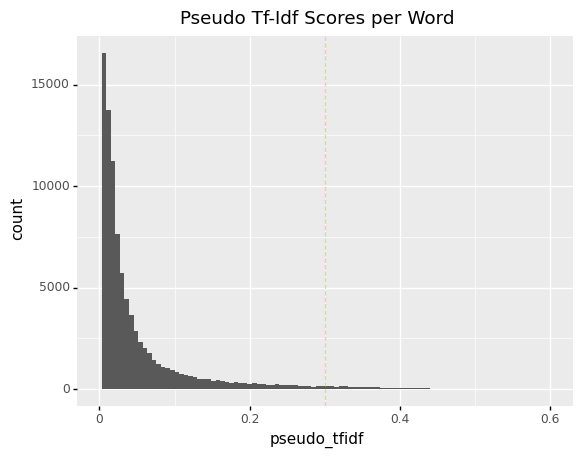

<ggplot: (7157283981)>

In [40]:
(ggplot(agg, aes(x='pseudo_tfidf')) + 
     geom_histogram(bins=100) + 
     geom_vline(xintercept = 0.3, linetype="dashed", color = "orange", alpha=0.5) +
     xlim(0,0.6) + 
     ggtitle('Pseudo Tf-Idf Scores per Word'))

In [27]:
fnl_word_df = (pd.DataFrame(agg.loc[agg['pseudo_tfidf'] > .3, 'word']
                               .drop_duplicates()
                               .reset_index(drop=True)))

In [31]:
piv = (pd.pivot_table(df.merge(fnl_word_df, on=['word']), 
                      index='track_id', 
                      columns='word', 
                      values='count', 
                      aggfunc='sum', 
                      fill_value=0)
         .reset_index())

In [32]:
piv.to_csv('/storage/thesis/lyrics/lyrics_piv_trunc.csv')